# Base Model & Transfer Learning
---
- Customize model based on MobileNet 
- 33 car models from 5 Car Brands(Hyundai, Kia, Genesis, Ssangyong, Renault)

**Load Library**

In [ ]:
# Utils
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import pathlib
import glob
import os
import random
import cv2

# Tensorflow & Keras
import tensorflow as tf
from tensorflow.keras.optimizers import RMSprop, Adam
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Dense,Flatten , Conv2D , MaxPooling2D , Dropout
from tensorflow.keras.models import Model , Sequential
from tensorflow.keras.layers.experimental.preprocessing import Rescaling
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing import image_dataset_from_directory

**Load Data**

In [ ]:
data_path = "/content/drive/MyDrive/프로젝트/b/"
data_dir = pathlib.Path(data_path)

**Define Train, Valid dataset from directory**

In [ ]:
train_ds = image_dataset_from_directory(
    data_dir,validation_split=0.25,
    subset='training',
    labels='inferred',
    label_mode='categorical',
    image_size=[224, 224],
    seed=123,
    interpolation='nearest',
    batch_size=64,
    # shuffle=True,
)
valid_ds = image_dataset_from_directory(
    data_dir,validation_split=0.25,
    subset='validation',
    labels='inferred',
    label_mode='categorical',
    image_size=[224, 224],
    seed=123,
    interpolation='nearest',
    batch_size=64,
    shuffle=False,
)
def convert_to_float(image, label):
    image = tf.image.convert_image_dtype(image, dtype=tf.float32)
    return image, label

AUTOTUNE = tf.data.experimental.AUTOTUNE
ds_train = (
    train_ds
    .map(convert_to_float)
    .cache()
    .prefetch(buffer_size=AUTOTUNE)
)
ds_valid = (
    valid_ds
    .map(convert_to_float)
    .cache()
    .prefetch(buffer_size=AUTOTUNE)
)

Found 9900 files belonging to 33 classes.
Using 7425 files for training.
Found 9900 files belonging to 33 classes.
Using 2475 files for validation.


**Transfer Learning**
- based on MobileNet
- Create Model (based on MobileNet) and then  train, evaluate , visualize Model

In [ ]:
from tensorflow.keras.applications.mobilenet import MobileNet
base_model = MobileNet(weights='imagenet', include_top=False, input_shape=(224,224,3))
for layer in base_model.layers:
  layer.trainable = True

In [ ]:
# Check Conv layers only 
num = 1
for layer in base_model.layers:
  if 'conv2d.Conv2D' in str(layer):
    print(layer, num)
  num += 1

<keras.layers.convolutional.conv2d.Conv2D object at 0x7eff0633fbb0> 2
<keras.layers.convolutional.conv2d.Conv2D object at 0x7eff06447190> 8
<keras.layers.convolutional.conv2d.Conv2D object at 0x7eff08201c70> 15
<keras.layers.convolutional.conv2d.Conv2D object at 0x7eff0619dc40> 21
<keras.layers.convolutional.conv2d.Conv2D object at 0x7eff0823bac0> 28
<keras.layers.convolutional.conv2d.Conv2D object at 0x7eff062c3100> 34
<keras.layers.convolutional.conv2d.Conv2D object at 0x7eff062e9c70> 41
<keras.layers.convolutional.conv2d.Conv2D object at 0x7eff062c3340> 47
<keras.layers.convolutional.conv2d.Conv2D object at 0x7eff08277340> 53
<keras.layers.convolutional.conv2d.Conv2D object at 0x7eff0624c580> 59
<keras.layers.convolutional.conv2d.Conv2D object at 0x7eff0624c7f0> 65
<keras.layers.convolutional.conv2d.Conv2D object at 0x7eff06332220> 71
<keras.layers.convolutional.conv2d.Conv2D object at 0x7eff06273880> 78
<keras.layers.convolutional.conv2d.Conv2D object at 0x7eff060f91c0> 84


**Trial 1- Transfer Learning with MobileNet**

In [ ]:
# Create Model 
model = Sequential()
model.add(Rescaling(1./255 ,input_shape=(224,224,3)))
model.add(base_model)
model.add(Conv2D(16, 3, padding='same', activation='relu'))
model.add(MaxPooling2D())
model.add(Dropout(0.2))

model.add(Conv2D(32, 3, padding='same', activation='relu'))
model.add(MaxPooling2D())
model.add(Conv2D(64, 3, padding='same', activation='relu'))
model.add(MaxPooling2D())
model.add(Dropout(0.2))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(33 , activation = 'softmax'))

# model.summary()
model.compile(loss='categorical_crossentropy',optimizer=Adam(learning_rate=0.0001) , metrics=['accuracy'])

In [ ]:
# Model Architecture
from keras.utils.vis_utils import plot_model
plot_model(model, to_file='/content/drive/MyDrive/프로젝트/model_plot.jpg', show_shapes=True, show_layer_names=True)

In [ ]:
# Train Model 
hist = model.fit(ds_train,batch_size=64,epochs=20,validation_data=ds_valid)

Epoch 1/20
117/117 [==============================] - 1056s 9s/step - loss: 3.4044 - accuracy: 0.0535 - val_loss: 3.1457 - val_accuracy: 0.1172
Epoch 2/20
117/117 [==============================] - 9s 76ms/step - loss: 3.0942 - accuracy: 0.1574 - val_loss: 2.8236 - val_accuracy: 0.2614
Epoch 3/20
117/117 [==============================] - 9s 75ms/step - loss: 2.8344 - accuracy: 0.2280 - val_loss: 2.6405 - val_accuracy: 0.2986
Epoch 4/20
117/117 [==============================] - 10s 82ms/step - loss: 2.6635 - accuracy: 0.2818 - val_loss: 2.5122 - val_accuracy: 0.3378
Epoch 5/20
117/117 [==============================] - 9s 75ms/step - loss: 2.5373 - accuracy: 0.3211 - val_loss: 2.4477 - val_accuracy: 0.3446
Epoch 6/20
117/117 [==============================] - 9s 74ms/step - loss: 2.4322 - accuracy: 0.3576 - val_loss: 2.3874 - val_accuracy: 0.3584
Epoch 7/20
117/117 [==============================] - 9s 74ms/step - loss: 2.3466 - accuracy: 0.3791 - val_loss: 2.3369 - val_accuracy: 0.38

In [ ]:
# Evaluate Model 
model.evaluate(ds_train), model.evaluate(ds_valid)

39/39 [==============================] - 1s 30ms/step - loss: 1.4783 - accuracy: 0.6105


([1.2085429430007935, 0.675151526927948],
 [1.4783203601837158, 0.6105050444602966])

**Trial 2 - Transfer Learning with MobileNet**

In [ ]:
# Create Model 
model1 = Sequential()
model1.add(tf.keras.layers.experimental.preprocessing.Rescaling(1./255, input_shape=(224,224,3)))
model1.add(base_model)
model1.add(Conv2D(16, 3, padding='same', activation='relu'))
model1.add(MaxPooling2D(padding='same'))
model1.add(Dropout(0.2))
model1.add(Conv2D(32, 3, padding='same', activation='relu'))
model1.add(MaxPooling2D(padding='same'))
model1.add(Conv2D(64, 3, padding='same', activation='relu'))
model1.add(MaxPooling2D(padding='same'))
model1.add(Dropout(0.2))
model1.add(Flatten())
model1.add(Dense(128, activation='relu'))
model1.add(Dense(33 , activation = 'softmax'))
# model.summary()
model1.compile(loss='categorical_crossentropy',optimizer=Adam(learning_rate=0.001) , metrics=['accuracy'])

In [ ]:
# Train Model
hist = model1.fit(ds_train,batch_size=64,epochs=20,validation_data=ds_valid)

Epoch 1/20
117/117 [==============================] - 61s 479ms/step - loss: 2.5111 - accuracy: 0.2646 - val_loss: 4.1721 - val_accuracy: 0.2036
Epoch 2/20
117/117 [==============================] - 46s 390ms/step - loss: 1.5262 - accuracy: 0.5397 - val_loss: 1.7323 - val_accuracy: 0.5604
Epoch 3/20
117/117 [==============================] - 45s 381ms/step - loss: 1.0803 - accuracy: 0.6707 - val_loss: 1.2767 - val_accuracy: 0.6493
Epoch 4/20
117/117 [==============================] - 44s 377ms/step - loss: 0.9059 - accuracy: 0.7234 - val_loss: 1.8255 - val_accuracy: 0.6125
Epoch 5/20
117/117 [==============================] - 44s 380ms/step - loss: 0.7149 - accuracy: 0.7776 - val_loss: 1.4225 - val_accuracy: 0.6840
Epoch 6/20
117/117 [==============================] - 45s 382ms/step - loss: 0.6045 - accuracy: 0.8124 - val_loss: 1.6280 - val_accuracy: 0.5665
Epoch 7/20
117/117 [==============================] - 45s 382ms/step - loss: 0.5640 - accuracy: 0.8232 - val_loss: 0.8026 - val_ac

In [ ]:
# Evaluate Model
model1.evaluate(ds_train), model1.evaluate(ds_valid)

39/39 [==============================] - 3s 71ms/step - loss: 0.9568 - accuracy: 0.7798


([1.0295538902282715, 0.7688888907432556],
 [0.9567987322807312, 0.7797979712486267])

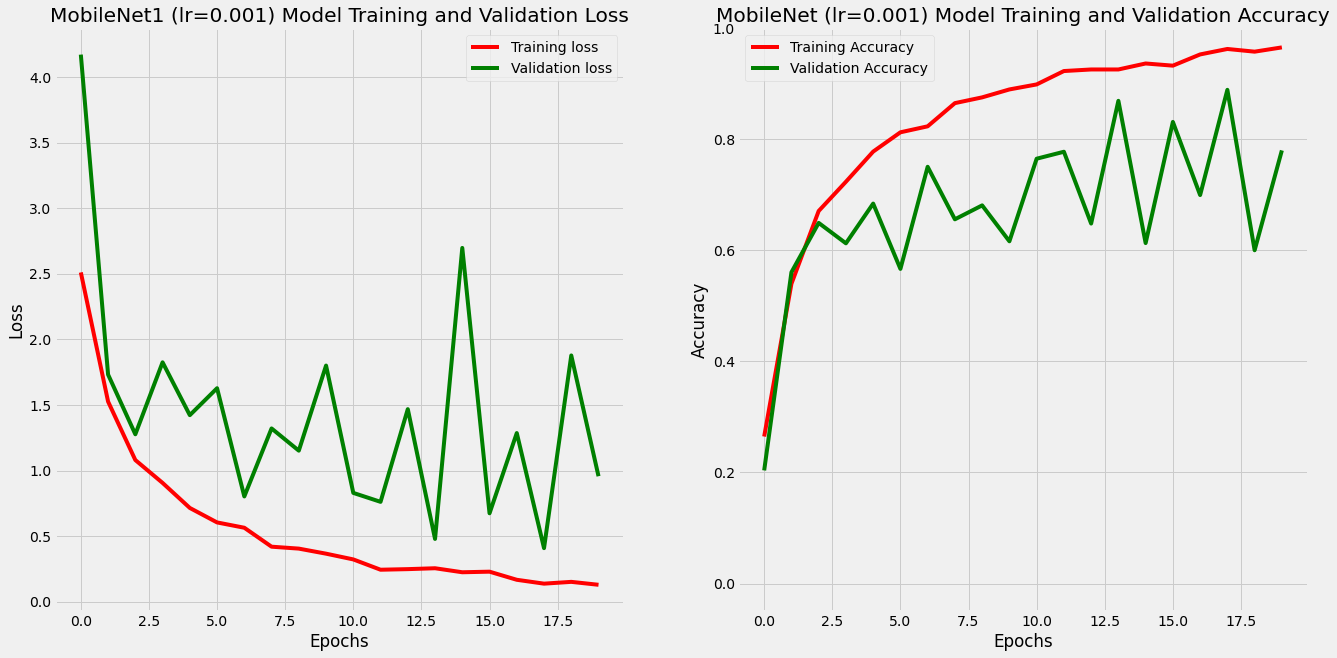

In [ ]:
# Visualization
plt.style.use('fivethirtyeight')
fig,axes=plt.subplots(nrows=1, ncols=2, figsize=(20,10))
axes[0].plot(hist.history["loss"], 'r', label='Training loss')
axes[0].plot(hist.history["val_loss"],'g',label='Validation loss' )
axes[0].set_title('MobileNet1 (lr=0.001) Model Training and Validation Loss')
axes[0].set_xlabel('Epochs')
axes[0].set_ylabel('Loss')
axes[0].legend()
plt.ylim(-0.05,1.0)
axes[1].plot (hist.history["accuracy"],'r',label= 'Training Accuracy')
axes[1].plot (hist.history["val_accuracy"],'g',label= 'Validation Accuracy')
axes[1].set_title('MobileNet (lr=0.001) Model Training and Validation Accuracy')
axes[1].set_xlabel('Epochs')
axes[1].set_ylabel('Accuracy')
axes[1].legend()

plt.savefig("/content/drive/MyDrive/프로젝트/MobileNet (lr=0.001)model_accuracy_loss.jpg")

**Base Model**
- Customized Model based on MobileNet Transfer Learning Trials

In [ ]:
# Base Model 
model2 = Sequential()
model2.add(tf.keras.layers.experimental.preprocessing.Rescaling(1./255, input_shape=(224,224,3)))
model2.add(Conv2D(16, 3, padding='same', activation='relu'))
model2.add(MaxPooling2D(padding='same'))
model2.add(Dropout(0.2))
model2.add(Conv2D(32, 3, padding='same', activation='relu'))
model2.add(MaxPooling2D(padding='same'))
model2.add(Conv2D(64, 3, padding='same', activation='relu'))
model2.add(MaxPooling2D(padding='same'))
model2.add(Dropout(0.2))
model2.add(Flatten())
model2.add(Dense(128, activation='relu'))
model2.add(Dense(33 , activation = 'softmax'))
# model.summary()
model2.compile(loss='categorical_crossentropy',optimizer=Adam(learning_rate=0.001) , metrics=['accuracy'])

In [ ]:
# Train Model 
hist2 = model2.fit(ds_train,batch_size=64,epochs=20,validation_data=ds_valid)

Epoch 1/20
117/117 [==============================] - 41s 332ms/step - loss: 3.1944 - accuracy: 0.1185 - val_loss: 2.7133 - val_accuracy: 0.2812
Epoch 2/20
117/117 [==============================] - 9s 74ms/step - loss: 2.6489 - accuracy: 0.2671 - val_loss: 2.5370 - val_accuracy: 0.2986
Epoch 3/20
117/117 [==============================] - 9s 74ms/step - loss: 2.3215 - accuracy: 0.3522 - val_loss: 2.3448 - val_accuracy: 0.3321
Epoch 4/20
117/117 [==============================] - 9s 74ms/step - loss: 2.0691 - accuracy: 0.4251 - val_loss: 2.2179 - val_accuracy: 0.3624
Epoch 5/20
117/117 [==============================] - 9s 74ms/step - loss: 1.9045 - accuracy: 0.4761 - val_loss: 2.0541 - val_accuracy: 0.4065
Epoch 6/20
117/117 [==============================] - 9s 73ms/step - loss: 1.7571 - accuracy: 0.5178 - val_loss: 1.9005 - val_accuracy: 0.4606
Epoch 7/20
117/117 [==============================] - 8s 73ms/step - loss: 1.6257 - accuracy: 0.5576 - val_loss: 1.7907 - val_accuracy: 0.50

In [ ]:
# Evaluate Model 
model2.evaluate(ds_train), model2.evaluate(ds_valid)

39/39 [==============================] - 1s 33ms/step - loss: 0.9411 - accuracy: 0.7879


([0.5141890645027161, 0.8499663472175598],
 [0.9410769939422607, 0.7878788113594055])

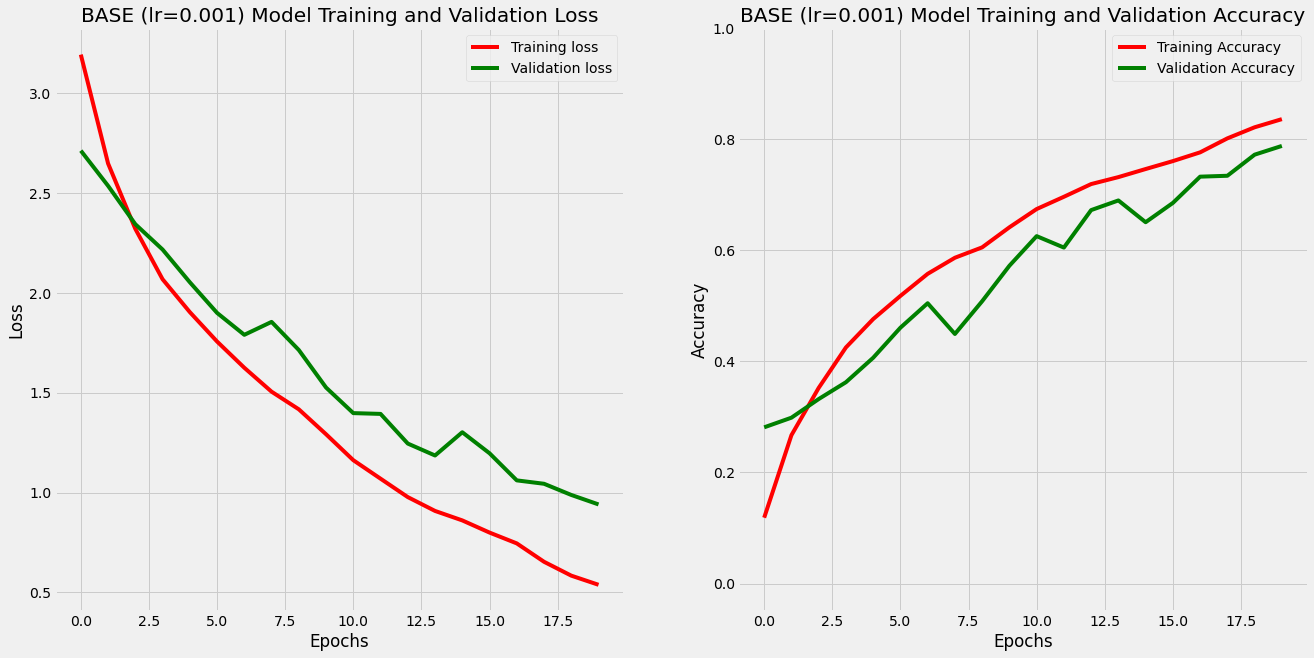

In [ ]:
# Visualization
plt.style.use('fivethirtyeight')
fig,axes=plt.subplots(nrows=1, ncols=2, figsize=(20,10))
axes[0].plot(hist2.history["loss"], 'r', label='Training loss')
axes[0].plot(hist2.history["val_loss"],'g',label='Validation loss' )
axes[0].set_title('BASE (lr=0.001) Model Training and Validation Loss')
axes[0].set_xlabel('Epochs')
axes[0].set_ylabel('Loss')
axes[0].legend()
plt.ylim(-0.05,1.0)

axes[1].plot (hist2.history["accuracy"],'r',label= 'Training Accuracy')
axes[1].plot (hist2.history["val_accuracy"],'g',label= 'Validation Accuracy')
axes[1].set_title('BASE (lr=0.001) Model Training and Validation Accuracy')
axes[1].set_xlabel('Epochs')
axes[1].set_ylabel('Accuracy')
axes[1].legend()

plt.savefig("/content/drive/MyDrive/프로젝트/BASE(lr=0.001)model_accuracy_loss.jpg")

> Found that This Model can be applied to Transfer Learning in order to get better result 

**Trial 3 - Transfer Learning with MobileNet**
- Get layers from Base Model above and then apply to MobileNet Transfer Learning 

In [ ]:
# MobileNet Transfer Learning
from tensorflow.keras.applications.mobilenet import MobileNet
base_model = MobileNet(weights='imagenet', include_top=False, input_shape=(224,224,3))
for layer in base_model.layers:
  layer.trainable = True

In [ ]:
# Crate Model 
model3 = Sequential()
model3.add(tf.keras.layers.experimental.preprocessing.Rescaling(1./255, input_shape=(224,224,3)))
model3.add(base_model)
model3.add(Conv2D(16, 3, padding='same', activation='relu'))
model3.add(MaxPooling2D(padding='same'))
model3.add(Dropout(0.2))
model3.add(Conv2D(32, 3, padding='same', activation='relu'))
model3.add(MaxPooling2D(padding='same'))
model3.add(Conv2D(64, 3, padding='same', activation='relu'))
model3.add(MaxPooling2D(padding='same'))
model3.add(Dropout(0.2))
model3.add(Flatten())
model3.add(Dense(128, activation='relu'))
model3.add(Dense(33 , activation = 'softmax'))
model3.compile(loss='categorical_crossentropy',optimizer=Adam(learning_rate=0.0001) , metrics=['accuracy'])


In [ ]:
# Train Model
hist3 = model3.fit(ds_train,batch_size=64,epochs=20,validation_data=ds_valid)

Epoch 1/20
117/117 [==============================] - 62s 478ms/step - loss: 3.3936 - accuracy: 0.0681 - val_loss: 3.5531 - val_accuracy: 0.1152
Epoch 2/20
117/117 [==============================] - 45s 386ms/step - loss: 2.7039 - accuracy: 0.2343 - val_loss: 3.4973 - val_accuracy: 0.0642
Epoch 3/20
117/117 [==============================] - 44s 378ms/step - loss: 1.9135 - accuracy: 0.4502 - val_loss: 3.1930 - val_accuracy: 0.1042
Epoch 4/20
117/117 [==============================] - 45s 389ms/step - loss: 1.4410 - accuracy: 0.5867 - val_loss: 2.3551 - val_accuracy: 0.3491
Epoch 5/20
117/117 [==============================] - 46s 392ms/step - loss: 1.0423 - accuracy: 0.6909 - val_loss: 1.0756 - val_accuracy: 0.7188
Epoch 6/20
117/117 [==============================] - 46s 389ms/step - loss: 0.7831 - accuracy: 0.7632 - val_loss: 0.8121 - val_accuracy: 0.7685
Epoch 7/20
117/117 [==============================] - 45s 384ms/step - loss: 0.5691 - accuracy: 0.8268 - val_loss: 0.5363 - val_ac

In [ ]:
# Evaluate Model
model3.evaluate(ds_train), model3.evaluate(ds_valid)

39/39 [==============================] - 3s 69ms/step - loss: 0.2043 - accuracy: 0.9511


([0.01770494319498539, 0.9951515197753906],
 [0.20431873202323914, 0.9511111378669739])

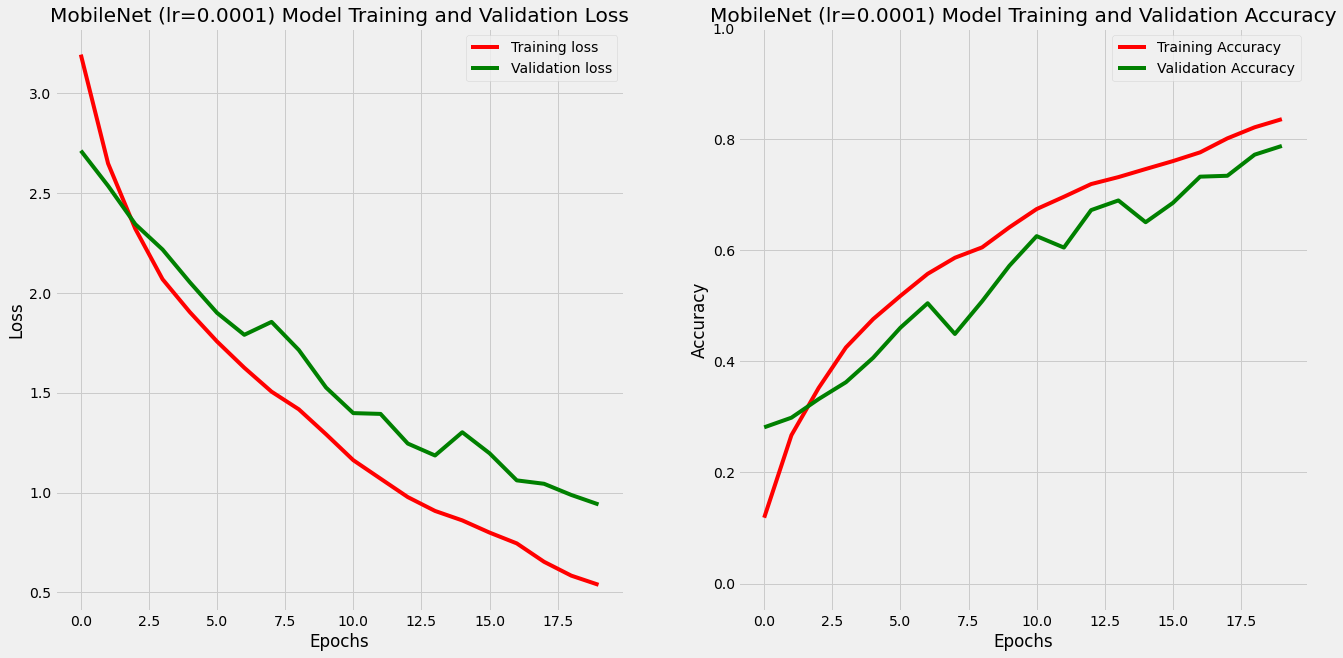

In [ ]:
# Visualization
plt.style.use('fivethirtyeight')
fig,axes=plt.subplots(nrows=1, ncols=2, figsize=(20,10))
axes[0].plot(hist2.history["loss"], 'r', label='Training loss')
axes[0].plot(hist2.history["val_loss"],'g',label='Validation loss' )
axes[0].set_title('MobileNet (lr=0.0001) Model Training and Validation Loss')
axes[0].set_xlabel('Epochs')
axes[0].set_ylabel('Loss')
axes[0].legend()
plt.ylim(-0.05,1.0)

axes[1].plot (hist2.history["accuracy"],'r',label= 'Training Accuracy')
axes[1].plot (hist2.history["val_accuracy"],'g',label= 'Validation Accuracy')
axes[1].set_title('MobileNet (lr=0.0001) Model Training and Validation Accuracy')
axes[1].set_xlabel('Epochs')
axes[1].set_ylabel('Accuracy')
axes[1].legend()

plt.savefig("/content/drive/MyDrive/프로젝트/MobileNet(lr=0.0001)model_accuracy_loss.jpg")